In [1]:
# Import necessary libraries
import mne
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # For better color palettes
from IPython.display import Image, display
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder # For encoding gender

# Potentially large/slow imports for Wav2Vec2
try:
    import torch
    import librosa # For resampling
    from transformers import Wav2Vec2Processor, Wav2Vec2Model
    WAV2VEC2_AVAILABLE = True
    print("PyTorch, Librosa, and Transformers loaded.")
except ImportError:
    WAV2VEC2_AVAILABLE = False
    print("Warning: PyTorch, Librosa, or Transformers not found. Wav2Vec2 analysis will be skipped.")
    print("Install them: pip install torch transformers librosa")

PyTorch, Librosa, and Transformers loaded.


In [2]:
# Define the base path to the dataset
base_path = '../recordings/ds006036/'
participants_tsv_path = os.path.join(base_path, 'participants.tsv')

# Configure matplotlib to display plots inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['figure.dpi'] = 100

In [3]:
participants_df = None
try:
    participants_df = pd.read_csv(participants_tsv_path, sep='\t')
    participants_df.set_index('participant_id', inplace=True)
    print("Successfully loaded participants.tsv:")
    print(f"Initial rows: {len(participants_df)}")
    participants_df.dropna(subset=['Age', 'Gender'], inplace=True)
    print(f"Rows after dropping NA in Age/Gender: {len(participants_df)}")
    gender_encoder = LabelEncoder()
    participants_df['Gender_Encoded'] = gender_encoder.fit_transform(participants_df['Gender'])
    print("Gender mapping:", dict(zip(gender_encoder.classes_, gender_encoder.transform(gender_encoder.classes_))))
    display(participants_df.head())
    print("\nGroup counts (after potential drops):")
    print(participants_df['Group'].value_counts())
except FileNotFoundError:
    print(f"Error: participants.tsv not found at {participants_tsv_path}")
except Exception as e:
    print(f"Error loading or processing participants.tsv: {e}")

Successfully loaded participants.tsv:
Initial rows: 88
Rows after dropping NA in Age/Gender: 88
Gender mapping: {'F': np.int64(0), 'M': np.int64(1)}


,Gender,Age,Group,MMSE,Gender_Encoded
participant_id,,,,,
sub-001,F,57,A,16,0
sub-002,F,78,A,22,0
sub-003,M,70,A,14,1
sub-004,F,67,A,20,0
sub-005,M,70,A,22,1



Group counts (after potential drops):
Group
A    36
C    29
F    23
Name: count, dtype: int64


'sub-001' not found in pre-loaded data. Attempting direct load...
Successfully loaded data directly for sub-001.

--- Basic Info & Raw Plot (sub-001) ---
<RawEEGLAB | sub-001_task-photomark_eeg.set, 19 x 164950 (329.9 s), ~23.9 MiB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 19 EEG
 custom_ref_applied: False
 dig: 19 items (19 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 19
 projs: []
 sfreq: 500.0 Hz
>

Plotting raw data...
Using matplotlib as 2D backend.


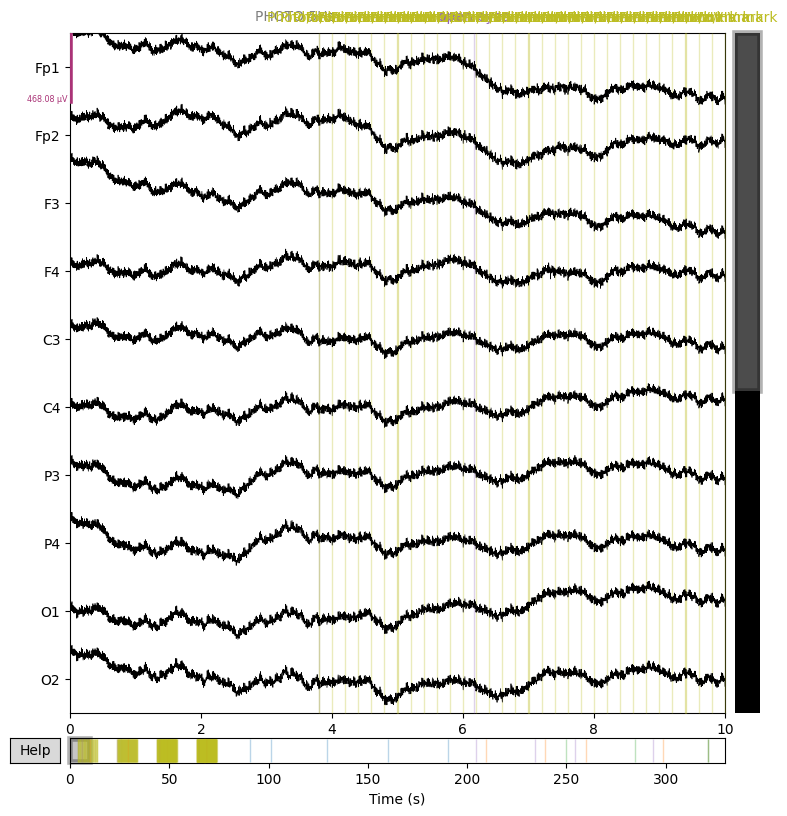

Raw EEG plot displayed inline

--- PSD (sub-001) --- 

Computing/plotting PSD...
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
PSD plot displayed inline

--- t-SNE on PSD Features (sub-001) --- 
Created 10 epochs.
Feature matrix shape: (10, 159)
Applying t-SNE...
t-SNE embedding shape: (10, 2)
Plotting t-SNE embedding...


/opt/homebrew/lib/python3.13/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/opt/homebrew/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Single subject t-SNE plot displayed inline


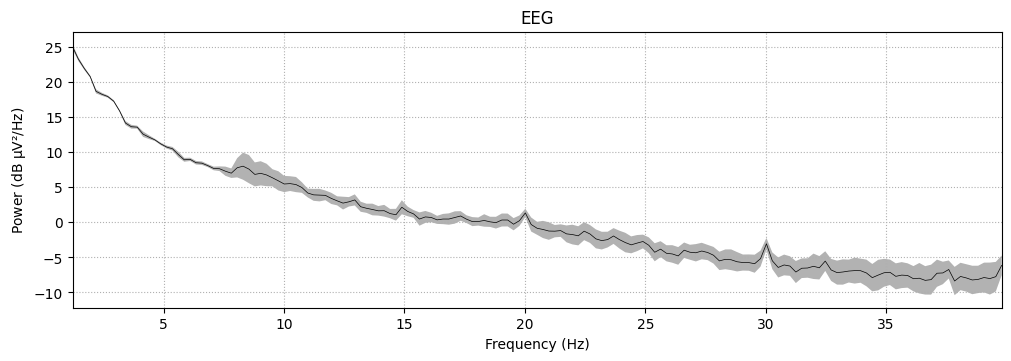

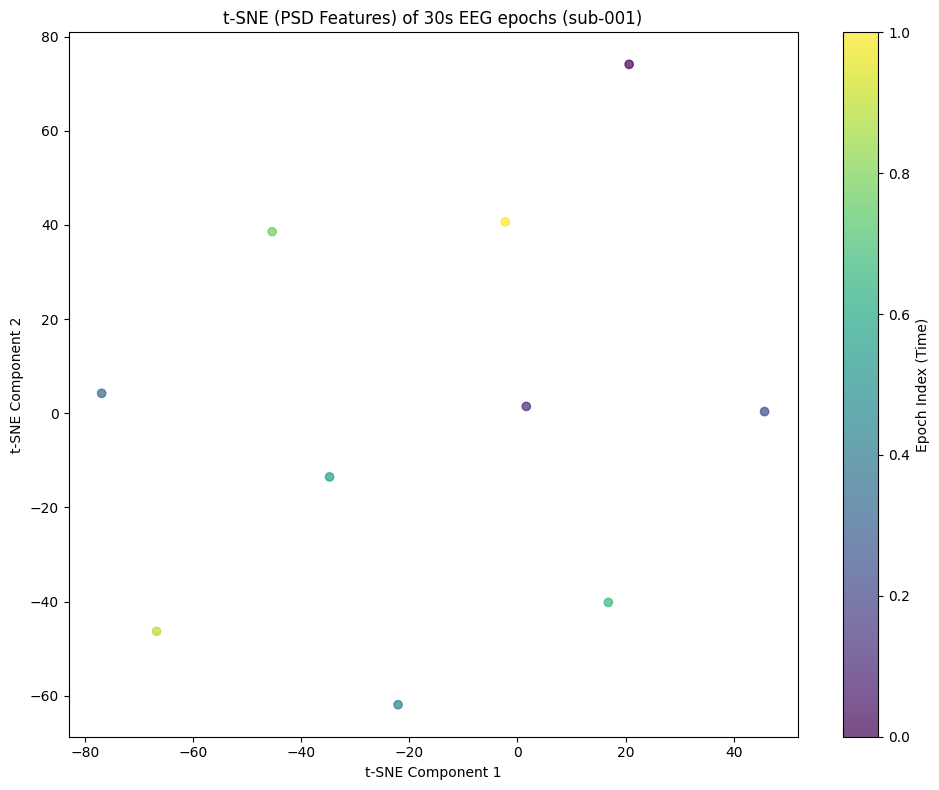

In [5]:
# Select data for sub-001 for the subsequent analysis cells
participant_to_analyze = 'sub-001'
raw_single = None

print(f"'{participant_to_analyze}' not found in pre-loaded data. Attempting direct load...")
single_file_path = os.path.join(base_path, participant_to_analyze, 'eeg', f'{participant_to_analyze}_task-photomark_eeg.set')
if not os.path.exists(single_file_path):
    raise FileNotFoundError(f"File not found at {single_file_path}.")
raw_single = mne.io.read_raw_eeglab(single_file_path, preload=True, verbose=False)
print(f"Successfully loaded data directly for {participant_to_analyze}.")



if raw_single:
    # Basic Info & Raw Plot
    print("\n--- Basic Info & Raw Plot (sub-001) ---")
    print(raw_single); print(raw_single.info)
    print("\nPlotting raw data...")
    fig_raw = raw_single.plot(n_channels=10, duration=10, scalings='auto', title=f'Raw EEG ({participant_to_analyze})')
    fig_raw.set_size_inches(15, 8)
    print("Raw EEG plot displayed inline")

    # PSD Plot
    print("\n--- PSD (sub-001) --- ")
    print("\nComputing/plotting PSD...")
    spectrum_raw = raw_single.compute_psd(fmin=1, fmax=40)
    fig_psd = spectrum_raw.plot(average=True, spatial_colors=True)
    print("PSD plot displayed inline")

    # t-SNE on Epoch Features (Single Subject, PSD)
    print(f"\n--- t-SNE on PSD Features ({participant_to_analyze}) --- ")
    epoch_length = 30
    try:
        epochs = mne.make_fixed_length_epochs(raw_single, duration=epoch_length, preload=True, verbose=False)
        print(f"Created {len(epochs)} epochs.")
        fmin, fmax = 1., 40.
        spectrum_epochs = epochs.compute_psd(method='welch', fmin=fmin, fmax=fmax, picks='eeg', verbose=False)
        psds, freqs = spectrum_epochs.get_data(return_freqs=True)
        X = psds.mean(axis=1)
        print(f"Feature matrix shape: {X.shape}")
        if X.shape[0] > 1:
            print("Applying t-SNE...")
            perplexity_value = min(30, X.shape[0] - 1)
            tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value, n_iter=300, verbose=0)
            X_embedded = tsne.fit_transform(X)
            print(f"t-SNE embedding shape: {X_embedded.shape}")
            print("Plotting t-SNE embedding...")
            fig_tsne, ax = plt.subplots(figsize=(10, 8))
            colors = plt.cm.viridis(np.linspace(0, 1, X_embedded.shape[0]))
            scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors, alpha=0.7)
            ax.set_title(f't-SNE (PSD Features) of {epoch_length}s EEG epochs ({participant_to_analyze})')
            ax.set_xlabel('t-SNE Component 1'); ax.set_ylabel('t-SNE Component 2')
            cbar = plt.colorbar(scatter, ax=ax, label='Epoch Index (Time)')
            plt.tight_layout()
            print("Single subject t-SNE plot displayed inline")
        else: print("Skipping t-SNE: Not enough epochs.")
    except Exception as e: print(f"Error during single-subject epoching/t-SNE: {e}")
else: print("\nSkipping single-subject analysis: data loading failed or subject not in cleaned metadata.")